In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datasets.skyline12 import Skyline12
from sklearn.model_selection import train_test_split

skyline12 = Skyline12('/storage/skyline12/data')
train_set, test_set = train_test_split(list(skyline12), train_size=100, random_state=0)
train_set, validation_set = train_test_split(train_set, train_size=0.8, random_state=42)
len(train_set), len(validation_set), len(test_set)

(80, 20, 20)

In [3]:
import tensorflow as tf
from datasets.skyline12 import create_augment_fn
from functools import partial

NUM_CLASSES = 5
FOLDS = 10


def ds_gen(sample_set, folds):
    augment = create_augment_fn()

    def preprocess(x, y, z):
        x, y, z = augment(x, y, z)
        x = x.astype('float32')
        x /= 255.0
        y[y >= NUM_CLASSES - 1] = NUM_CLASSES - 1
        y = tf.keras.utils.to_categorical(y, num_classes=NUM_CLASSES)
        z[z > 0] = 1
        z = tf.keras.utils.to_categorical(z, num_classes=2)
        return x, y, z

    for _ in range(folds):
        for x, y, z in sample_set:
            yield preprocess(x, y, z)


def split_outputs(x, y, z):
    return (x, (y, z))


train_ds = tf.data.Dataset.from_generator(
    partial(ds_gen, train_set, FOLDS),
    (
        tf.dtypes.float32,
        tf.dtypes.uint8,
        tf.dtypes.uint8
    ),
    (
        tf.TensorShape([512, 512, 3]),
        tf.TensorShape([512, 512, NUM_CLASSES]),
        tf.TensorShape([512, 512, 2])
    )
).map(split_outputs)
validation_ds = tf.data.Dataset.from_generator(
    partial(ds_gen, validation_set, FOLDS // 2),
    (
        tf.dtypes.float32,
        tf.dtypes.uint8,
        tf.dtypes.uint8
    ),
    (
        tf.TensorShape([512, 512, 3]),
        tf.TensorShape([512, 512, NUM_CLASSES]),
        tf.TensorShape([512, 512, 2])
    )
).map(split_outputs)

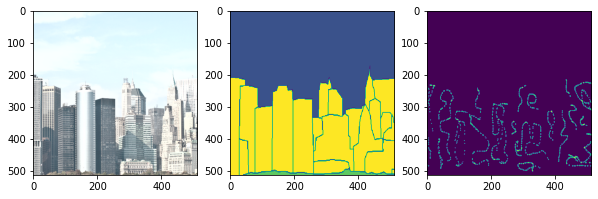

In [9]:
img, [annot, seed] = next(iter(train_ds))
Skyline12.show_sample(img, [annot, seed], from_tensors=True)

In [ ]:
import wandb
wandb.init(project="skyline12-evidence", tags=['sweepable'], config={
    'epochs': 10,
    'q_loss': None,
    'lambda': 0.1,
    'q_learning_rate': 1e-5,
    'q_optimizer': 'sgd',
}, notes='try to predict evidence from feature map of 64 depth')
hyperparams = wandb.config

In [ ]:
from models.unet import create_unet
from tensorflow.keras.layers import Input, Conv2D
from metrics import CategoricalMeanIou

unet = create_unet()
unet.load_weights('checkpoints/baseline-weights.h5')

img = Input(shape=(512, 512, 3), name='X')
intermid_unet = tf.keras.Model(unet.input, [unet.output, unet.layers[-2].output], name='Unet')
[x, v] = intermid_unet(img)
v = Conv2D(2, (1, 1), padding='same', kernel_initializer='he_normal', activation='softmax', name='Q')(v)
evid_model = tf.keras.Model(inputs=img, outputs=[x, v])
if hyperparams.get('q_optimizer') == 'adam':
    optimizer = tf.keras.optimizers.Adam(learning_rate=hyperparams.get('q_learning_rate'))
elif hyperparams.get('q_optimizer') == 'sgd':
    optimizer = tf.keras.optimizers.SGD(learning_rate=hyperparams.get('q_learning_rate'), momentum=0.99)
else:
    optimizer = hyperparams.get('q_optimizer')
evid_model.compile(
    optimizer=optimizer,
    loss=['categorical_crossentropy', hyperparams.get('q_loss')],
    loss_weights=[1.0, hyperparams.get('lambda')],
    metrics=[[CategoricalMeanIou(num_classes=5), 'accuracy'], ['accuracy']],
    run_eagerly=False
)

In [ ]:
!rm -rf temp
!mkdir -p temp

In [ ]:
import wandb
from wandb.keras import WandbCallback
from callbacks import WandbLogEvidencePredictions

early_stopper = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
class_labels = {
    0: 'Borders',
    1: 'Sky',
    2: 'Unknown',
    3: 'Unknown',
    4: 'Skyscrapers',
}
data_to_log = next(iter(validation_ds.batch(10)))
log_predictions = WandbLogEvidencePredictions(data_to_log, class_labels)

AUTOTUNE = tf.data.experimental.AUTOTUNE
evid_model.fit(
    train_ds.batch(3).cache('temp/').prefetch(AUTOTUNE),
    epochs=hyperparams.get('epochs'),
    validation_data=validation_ds.batch(3).cache('temp/').prefetch(AUTOTUNE),
    callbacks=[
        early_stopper,
        WandbCallback(),
        log_predictions
    ]
)

In [ ]:
foo_x, [foo_y, foo_z] = next(iter(validation_ds.batch(1)))
y_pred, z_pred = evid_model(foo_x, training=False)
Skyline12.show_sample(foo_x[0], [y_pred[0], z_pred[0]], from_tensors=True)